# Inpainting vs Denoising: Which "Gaussian Noise" is used 

This notebook is a **visual check** to clarify:

- **Masked inpainting (missing pixels):** the hole is **unknown**, so a noise initialization (Gaussian / uniform / constant) is needed 
  
- **Denoising (noise everywhere):** pixels are observed but corrupted, so noise should be **additive**

We'll visualize both and show why **"additive Gaussian" is not the same task** as masked inpainting.

Loading the pictures:

In [18]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch

# analyses/ is one level below repo root
REPO_ROOT = Path.cwd().parent
sys.path.insert(0, str(REPO_ROOT))

from nftm_inpaint.rollout import corrupt_images


# CHANGE THIS to your folder inside the repo (relative to notebook, or absolute)
IMG_DIR = Path("../benchmarks/CelebAHQ/")

# file extensions supported
EXTS = {".png", ".jpg", ".jpeg", ".webp"}

def load_images_from_folder(img_dir: Path, max_n=8, img_size=64):
    paths = [p for p in sorted(img_dir.rglob("*")) if p.suffix.lower() in EXTS]
    if len(paths) == 0:
        raise FileNotFoundError(f"No images found in {img_dir} with extensions {EXTS}")
    paths = paths[:max_n]

    imgs_m11 = []
    for p in paths:
        im = Image.open(p).convert("RGB").resize((img_size, img_size), Image.BILINEAR)
        arr01 = np.asarray(im).astype(np.float32) / 255.0          # [0,1]
        arrm11 = arr01 * 2.0 - 1.0                                 # [-1,1]
        imgs_m11.append(arrm11)
    return np.stack(imgs_m11, axis=0), paths  # (N,H,W,3)

imgs, paths = load_images_from_folder(IMG_DIR, max_n=6, img_size=64)
print("Loaded:", len(paths))
for p in paths:
    print(" -", p)

Loaded: 6
 - ..\benchmarks\CelebAHQ\all_images\00000.jpg
 - ..\benchmarks\CelebAHQ\all_images\00001.jpg
 - ..\benchmarks\CelebAHQ\all_images\00002.jpg
 - ..\benchmarks\CelebAHQ\all_images\00003.jpg
 - ..\benchmarks\CelebAHQ\all_images\00004.jpg
 - ..\benchmarks\CelebAHQ\all_images\00005.jpg


Defining masks:

In [38]:
rng = np.random.default_rng(0)

def clamp_m11(x):
    return np.clip(x, -1.0, 1.0)

def to01(x_m11):
    return np.clip((x_m11 + 1.0) * 0.5, 0.0, 1.0)

def make_center_square_mask(H, W, frac=0.4):
    # 1=known, 0=missing
    M = np.ones((H, W, 1), dtype=np.float32)
    h = int(H * frac)
    w = int(W * frac)
    y0 = (H - h) // 2
    x0 = (W - w) // 2
    M[y0:y0+h, x0:x0+w, :] = 0.0
    return M

# Inpainting-style corruption (REPLACEMENT in the missing region)
# Produce an inpainting initialization I0 where:
#  - known pixels (M=1) stay exactly equal to the clean image x
#  - missing pixels (M=0) are REPLACED by Gaussian noise samples n ~ N(0, noise_std^2)
def corrupt_inpaint_replace_torch(clean_m11_np, M_np, noise_std=0.3, seed=0):
    torch.manual_seed(seed)

    img = torch.from_numpy(clean_m11_np).permute(2,0,1).unsqueeze(0).float()
    M   = torch.from_numpy(M_np).permute(2,0,1).unsqueeze(0).float()

    out = corrupt_images(
        img, M,
        noise_std=noise_std,
        noise_kind="gaussian",
        gaussian_additive=False   # <-- TRUE replacement
    )
    return out.squeeze(0).permute(1,2,0).cpu().numpy()



#  Denoising/restoration-style corruption (ADDITIVE noise) applied only inside the same region.
# Create a "noisy observation" y where the selected region still contains the true signal x,
# but corrupted by additive Gaussian noise:
#  - outside region (M=1): y = x  (unchanged)
#  - inside region (M=0):  y = x + n,  n ~ N(0, noise_std^2)
def corrupt_denoise_additive_in_region(imgs_m11, M, noise_std=0.3):
    # imgs_m11: (N,H,W,3) in [-1,1]
    # M: (H,W,1) with 1=known, 0=missing (we add noise where M=0)
    N, H, W, C = imgs_m11.shape
    n = rng.normal(0.0, noise_std, size=imgs_m11.shape).astype(np.float32)
    y = imgs_m11 + (1.0 - M[None, ...]) * n
    y = clamp_m11(y)
    return y, n

def corrupt_denoise_additive_in_region_torch(imgs_m11, M_np, noise_std=0.3, seed=0):
    torch.manual_seed(seed)

    imgs_t = torch.from_numpy(imgs_m11).permute(0,3,1,2).float()  # (N,3,H,W)
    M_t    = torch.from_numpy(M_np).permute(2,0,1).unsqueeze(0).float()
    M_t    = M_t.expand(imgs_t.shape[0], -1, -1, -1)

    y_t = corrupt_images(
        imgs_t, M_t,
        noise_std=noise_std,
        noise_kind="gaussian",
        gaussian_additive=True    # <-- ADDITIVE
    )

    return y_t.permute(0,2,3,1).cpu().numpy()

Visualizing the current gaussian noise implementation (inpainting replacement) vs additive gaussian noise:

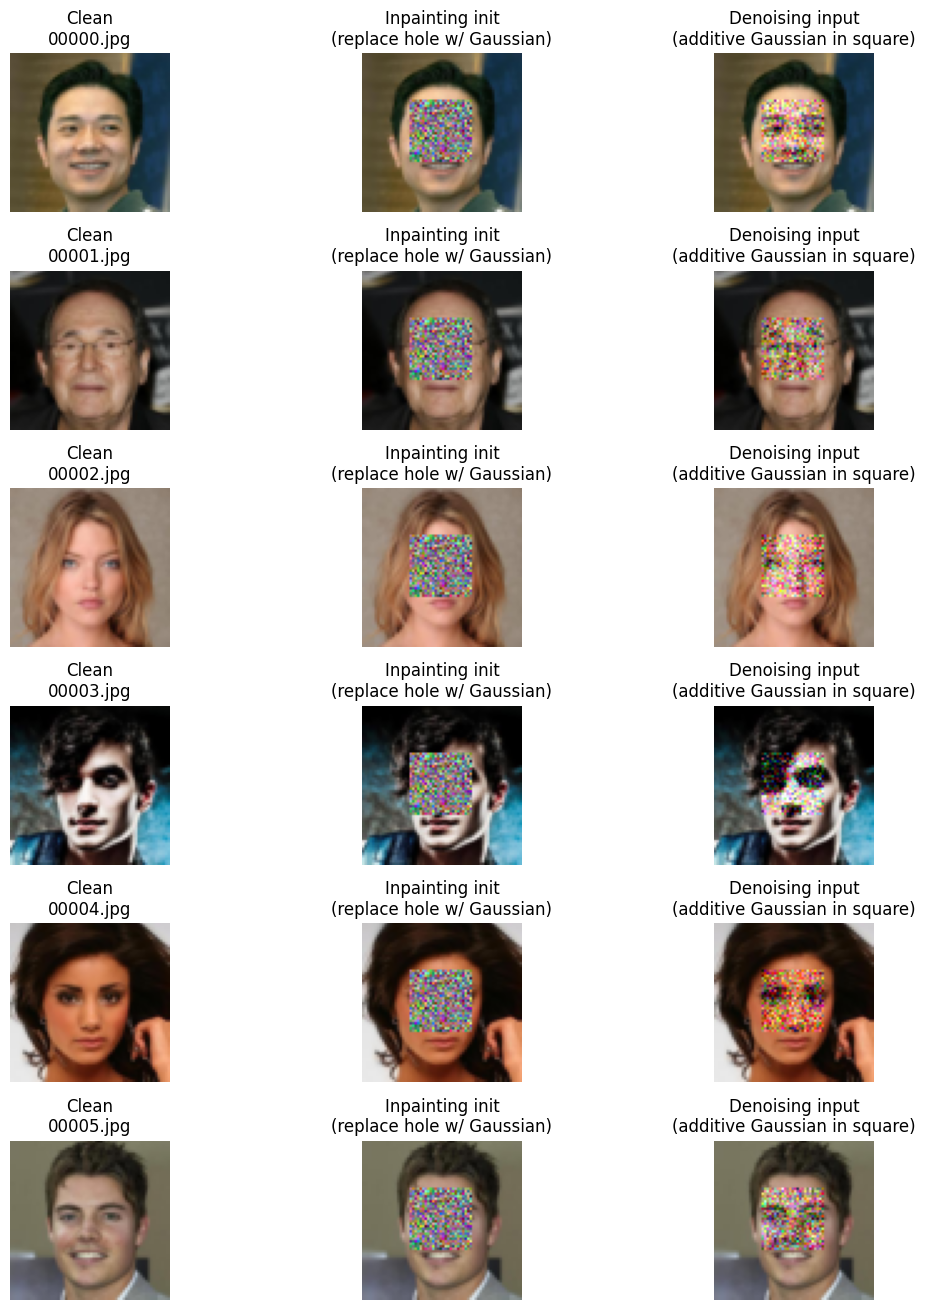

In [49]:
N, H, W, C = imgs.shape
M = make_center_square_mask(H, W, frac=0.4)

sigma = 0.4

# Build examples
inpaint_inputs = np.stack([corrupt_inpaint_replace_torch(imgs[i], M, noise_std=sigma) for i in range(N)], axis=0)
denoise_square_inputs, _ = corrupt_denoise_additive_in_region(imgs, M, noise_std=sigma)

# Plot grid: each row = one image
plt.figure(figsize=(12, 2.2*N))

for i in range(N):
    # Clean
    ax = plt.subplot(N, 3, 3*i + 1)
    ax.imshow(to01(imgs[i]))
    ax.set_title(f"Clean\n{paths[i].name}")
    ax.axis("off")

    # Inpainting init (replacement noise in hole)
    ax = plt.subplot(N, 3, 3*i + 2)
    ax.imshow(to01(inpaint_inputs[i]))
    ax.set_title("Inpainting init\n(replace hole w/ Gaussian)")
    ax.axis("off")

    # Denoising input (additive noise everywhere)
    ax = plt.subplot(N, 3, 3*i + 3)
    ax.imshow(to01(denoise_square_inputs[i]))
    ax.set_title("Denoising input\n(additive Gaussian in square)")
    ax.axis("off")

plt.tight_layout()
plt.show()


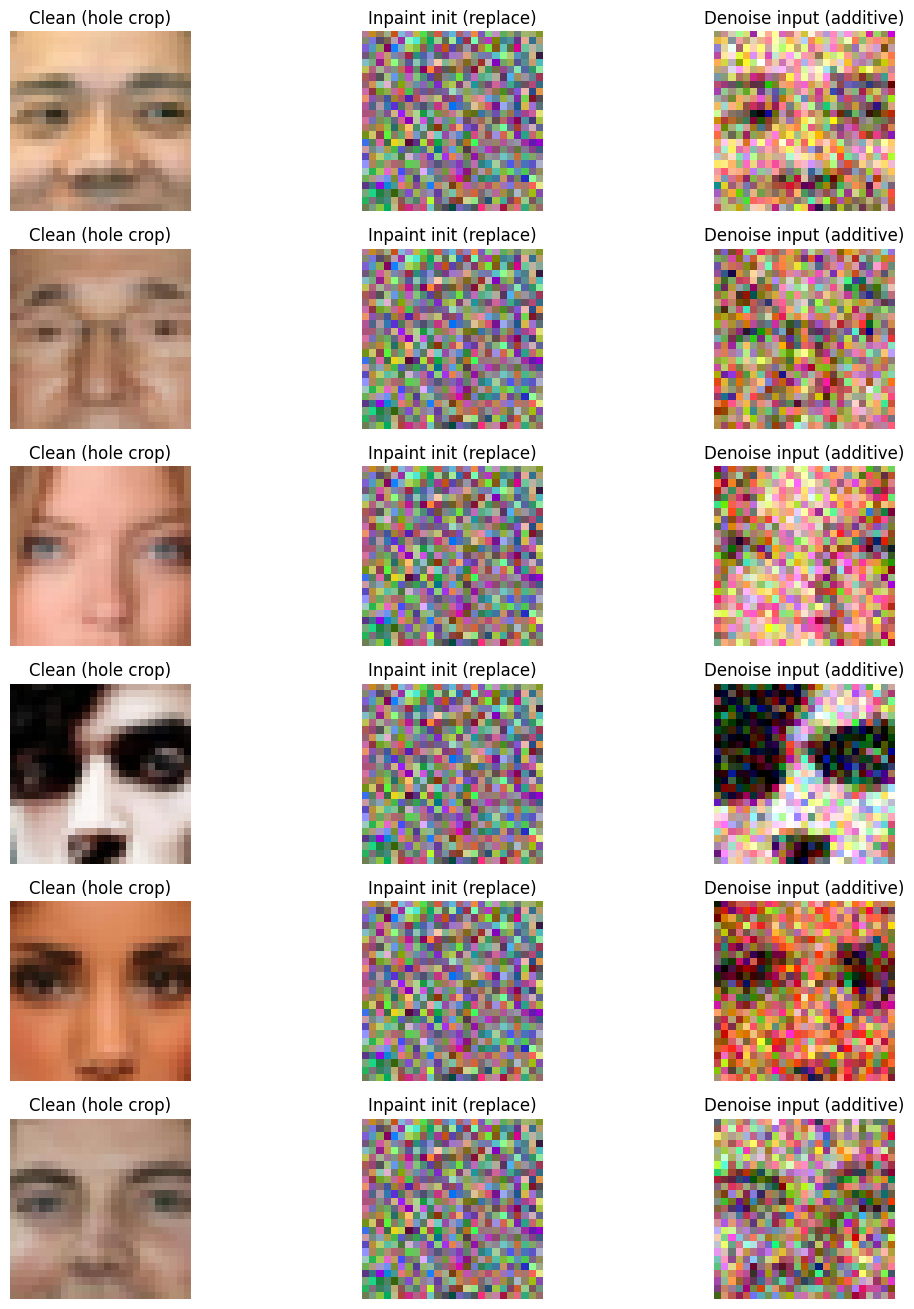

In [50]:
hole = (M.squeeze(-1) < 0.5)

plt.figure(figsize=(12, 2.2*N))
for i in range(N):
    # show just the hole crop for clarity
    y0, y1 = np.where(hole)[0].min(), np.where(hole)[0].max()+1
    x0, x1 = np.where(hole)[1].min(), np.where(hole)[1].max()+1

    ax = plt.subplot(N, 3, 3*i + 1)
    ax.imshow(to01(imgs[i][y0:y1, x0:x1]))
    ax.set_title("Clean (hole crop)")
    ax.axis("off")

    ax = plt.subplot(N, 3, 3*i + 2)
    ax.imshow(to01(inpaint_inputs[i][y0:y1, x0:x1]))
    ax.set_title("Inpaint init (replace)")
    ax.axis("off")

    ax = plt.subplot(N, 3, 3*i + 3)
    ax.imshow(to01(denoise_square_inputs[i][y0:y1, x0:x1]))
    ax.set_title("Denoise input (additive)")
    ax.axis("off")

plt.tight_layout()
plt.show()


- Inpainting replacement Gaussian (current guess): the hole contains no information about the true pixels. It’s just an initialization, not information. Practically we could fill those missing pixels with any color e.g black (IDEA FOR EXPERIMENT) but this could also teach the model that black pixel = missing pixel (overfitting the model) and thus it would be very difficult to restore pixels with actual ground truth of black color 

-->
Noise avoids giving the model a fixed visual cue (beyond the mask itself) and encourages it to use the mask + context, not the noise fill color itself

- Additive Gaussian denoising: pixels still contain the original structure + noise, so the observation is informative

Another example:

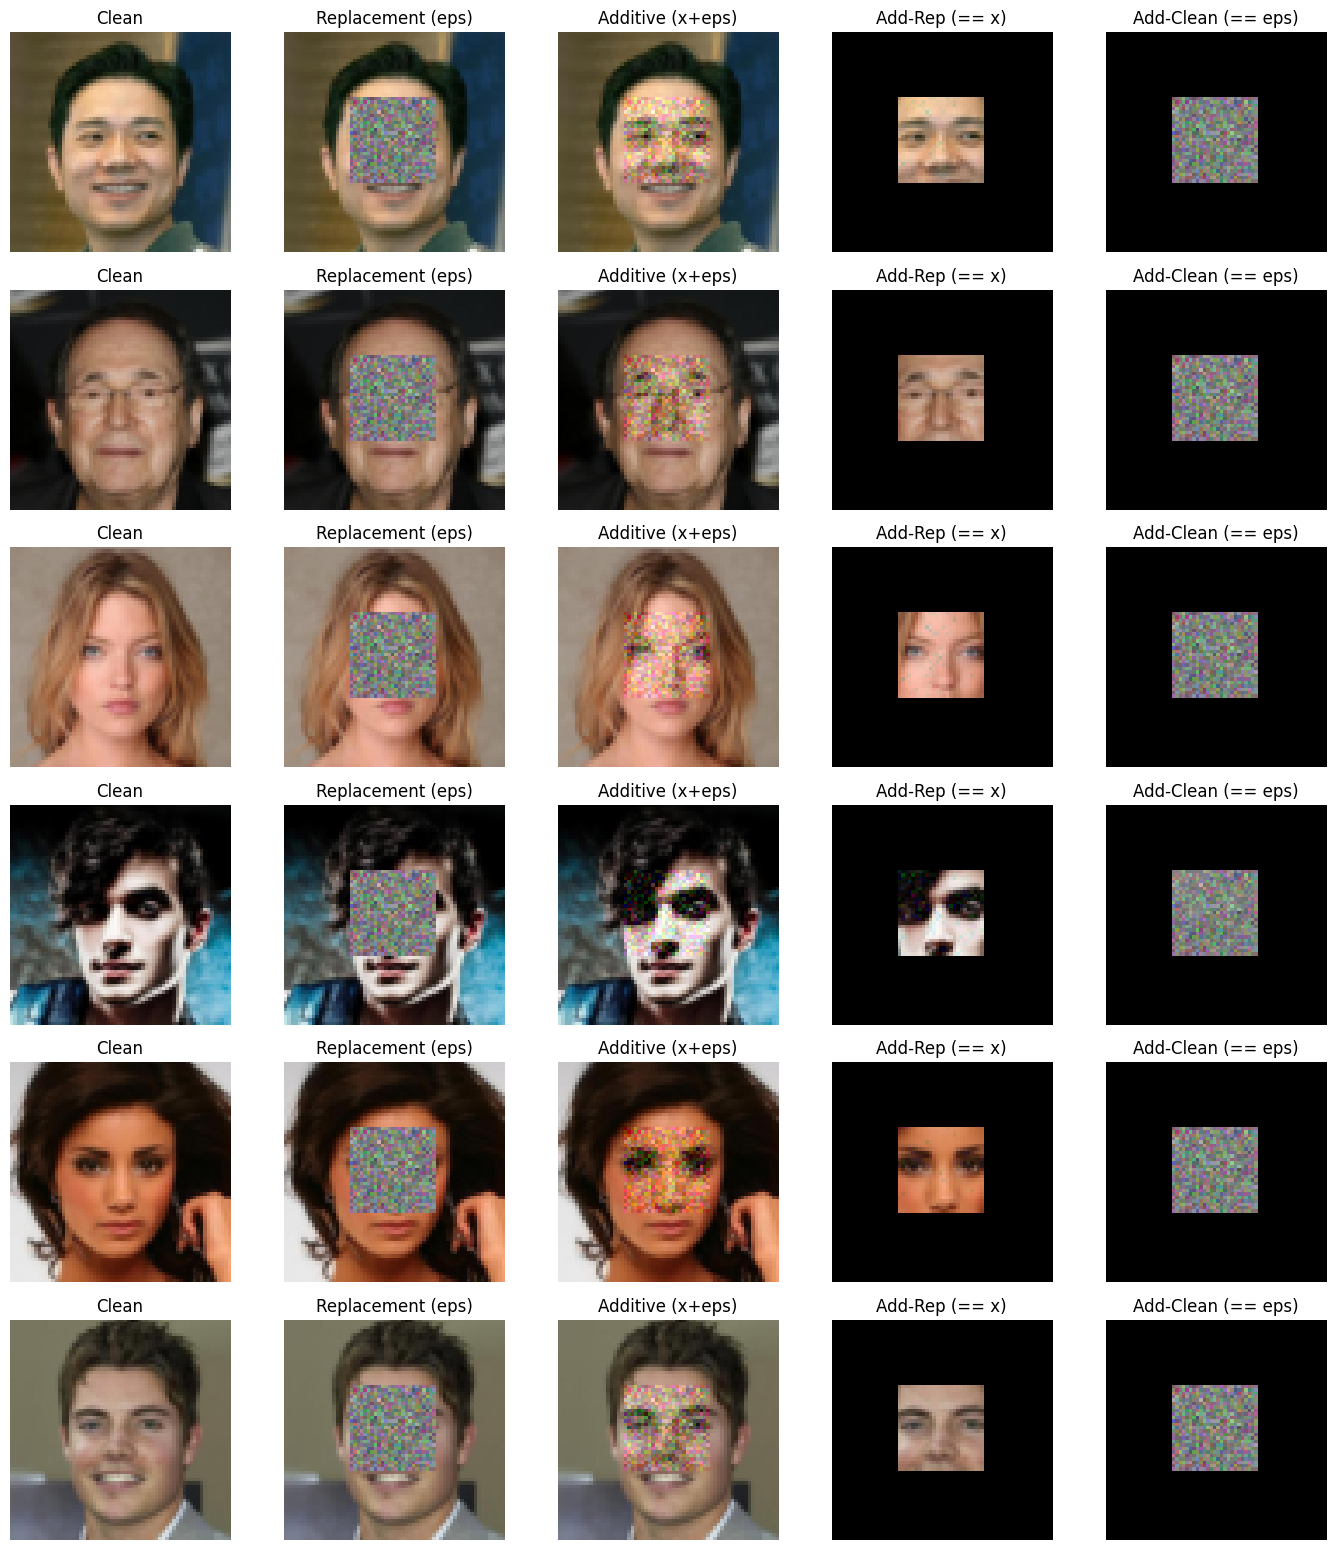

In [ ]:
import importlib
import nftm_inpaint.rollout as rollout
importlib.reload(rollout)

def corrupt_pair(clean_m11_np, M_np, noise_std=0.05, seed=0):
    x = torch.from_numpy(clean_m11_np).permute(2,0,1).unsqueeze(0).float()
    M = torch.from_numpy(M_np).permute(2,0,1).unsqueeze(0).float()
    hole = (1.0 - M)

    torch.manual_seed(seed)
    y_rep = rollout.corrupt_images(x, M, noise_std=noise_std, noise_kind="gaussian", gaussian_additive=False)

    torch.manual_seed(seed)
    y_add = rollout.corrupt_images(x, M, noise_std=noise_std, noise_kind="gaussian", gaussian_additive=True)

    x_np     = x.squeeze(0).permute(1,2,0).numpy()
    y_rep_np = y_rep.squeeze(0).permute(1,2,0).numpy()
    y_add_np = y_add.squeeze(0).permute(1,2,0).numpy()
    hole_np  = hole.squeeze(0).permute(1,2,0).numpy()  # (H,W,1)

    # Visual amplifiers
    add_minus_rep   = (y_add_np - y_rep_np) * hole_np                 # == x in hole
    add_minus_clean = (y_add_np - x_np) * hole_np                     # == eps in hole

    # Put something neutral outside hole so you see only the region
    bg = -1.0  # black in [-1,1]
    add_minus_rep_vis   = add_minus_rep   + (1.0 - hole_np) * bg
    add_minus_clean_vis = add_minus_clean + (1.0 - hole_np) * bg

    return x_np, y_rep_np, y_add_np, add_minus_rep_vis, add_minus_clean_vis

sigma = 0.2
seed0 = 123

plt.figure(figsize=(14, 2.6*N))
for i in range(N):
    x_np, y_rep_np, y_add_np, d1, d2 = corrupt_pair(imgs[i], M, noise_std=sigma, seed=seed0)

    ax = plt.subplot(N, 5, 5*i + 1); ax.imshow(to01(x_np));      ax.set_title("Clean"); ax.axis("off")
    ax = plt.subplot(N, 5, 5*i + 2); ax.imshow(to01(y_rep_np));  ax.set_title("Replacement (eps)"); ax.axis("off")
    ax = plt.subplot(N, 5, 5*i + 3); ax.imshow(to01(y_add_np));  ax.set_title("Additive (x+eps)"); ax.axis("off")
    ax = plt.subplot(N, 5, 5*i + 4); ax.imshow(to01(d1));        ax.set_title("Add-Rep (== x)"); ax.axis("off")
    ax = plt.subplot(N, 5, 5*i + 5); ax.imshow(to01(d2));        ax.set_title("Add-Clean (== eps)"); ax.axis("off")

plt.tight_layout()
plt.show()


## Running celebahq with optimal configuration on additive noise
